# Ensemble model

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os
os.chdir('../src/')
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from copy import deepcopy

from modules.training_module import TrainingModule
from modules.forecasting_module import ForecastingModule
from modules.model_evaluator import ModelEvaluator
from model_wrappers.model_factory import ModelFactory
from configs.base_config import TrainingModuleConfig
from configs.base_config import ForecastingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from nb_utils import train_eval, forecast
from nb_utils import plot_m1, plot_m2, plot_m3
# from nb_utils import set_dates

In [76]:
def set_dates(date, tq):
    d = dict()
    d['t1c_run'] = datetime.strftime(date - timedelta(1), "%-m/%-d/%y")
    d['t1c_start'] = datetime.strftime(date, "%-m/%-d/%y")
    d['t1c_end'] = datetime.strftime(date+timedelta(tq-1), "%-m/%-d/%y")
    d['t1b_start'] = datetime.strftime(date+timedelta(tq), "%-m/%-d/%y")
    d['t1b_end'] = datetime.strftime(date+timedelta(2*tq-1), "%-m/%-d/%y")
    d['test_start'] = datetime.strftime(date+timedelta(2*tq), "%-m/%-d/%y")
    d['test_end'] = datetime.strftime(date+timedelta(3*tq-1), "%-m/%-d/%y")
    return d

In [77]:
current_day = datetime.strptime("6/12/20", "%m/%d/%y") - timedelta(23)
dates = set_dates(current_day, tq = 7)
print(dates)

{'t1c_run': '5/19/20', 't1c_start': '5/20/20', 't1c_end': '5/26/20', 't1b_start': '5/27/20', 't1b_end': '6/2/20', 'test_start': '6/3/20', 'test_end': '6/9/20'}


## Code for training just the constituent models

In [4]:
with open('../config/sample_homogeneous_train_config.json') as f:
    trainc_config = json.load(f)

trainc_config['region_name'] = ['bengaluru urban']
trainc_config['region_type'] = 'district'
trainc_config['train_start_date'] = dates['t1c_start']
trainc_config['train_end_date'] = dates['t1c_end']
trainc_config['search_parameters']['max_evals'] = 1000
trainc_config['data_source'] = "direct_csv"
trainc_config['input_filepath'] = '/Users/harsh.maheshwari/Downloads/bengaluru_urban_july_16th.csv'
trainc_config['output_filepath'] = "../outputs/del-testing.json"

In [5]:
trainc_config

{'data_source': 'direct_csv',
 'region_name': ['bengaluru urban'],
 'region_type': 'district',
 'train_start_date': '5/20/20',
 'train_end_date': '5/26/20',
 'model_class': 'homogeneous_ensemble',
 'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'constituent_models',
   'predict_mode': 'mean_predictions'}},
 'search_space': {'r0': [0.5, 3],
  'exposed_ratio': [0.001, 10],
  'active_ratio': [0.001, 2],
  'infectious_period': [1, 10],
  'recovery_period': [1, 15],
  'deceased_period': [1, 15],
  'recovered_ratio': [0.7, 1],
  'beta': [0, 2]},
 'search_parameters': {'child_model': {'max_evals': 10},
  'ensemble_model': {'max_evals': 10},
  'frac_for_child': 0.5,
  'max_evals': 1000},
 'training_loss_function': {'metric_name': 'mape',
  'variable_weights': [{'variable': 'confirmed', 

In [6]:
trainc_config = TrainingModuleConfig.parse_obj(trainc_config)

In [9]:
trainc_output = TrainingModule.from_config(trainc_config)

100%|██████████| 1000/1000 [00:57<00:00, 17.48trial/s, best loss: 7.665398989798511]


In [10]:
trainc_output

{'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'constituent_models',
   'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.23529320045731722,
     'deceased_period': 10.746141178957046,
     'exposed_ratio': 0.021305583501909406,
     'infectious_period': 3.000356340603214,
     'r0': 1.634565300398837,
     'recovered_ratio': 0.9485290206002538,
     'recovery_period': 14.647340118439589,
     'Latent_exposed_ratio': {'5/19/20': 0.021305583501909406,
      '5/26/20': 0.1169238029286703},
     'Latent_active_ratio': {'5/19/20': 0.23529320045731722,
      '5/26

# Code for evaluation

In [24]:
consModelLoss = dict()
models = trainc_output['model_parameters']['constituent_models']
losses = trainc_output['model_parameters']['constituent_model_losses']
for idx in models.keys():
    with open('../config/sample_evaluation_config.json') as f:
        test1c_config = json.load(f)
    test1c_config['region_name'] = ['bengaluru urban']
    test1c_config['region_type'] = 'district'
    test1c_config['run_day'] = dates['t1c_end']
    test1c_config['test_start_date'] = dates['t1b_start']
    test1c_config['test_end_date'] = dates['t1b_end']
    test1c_config['data_source'] = "direct_csv"
    test1c_config['input_filepath'] = '/Users/harsh.maheshwari/Downloads/bengaluru_urban_july_16th.csv'
    test1c_config['model_parameters'] = models[idx]['model_parameters']
    test1c_config['output_filepath'] = "../outputs/del-testing.json"
    
    test1c_config = ModelEvaluatorConfig.parse_obj(test1c_config)
    test1c_output = ModelEvaluator.from_config(test1c_config)
    consModelLoss[idx] = dict()
    consModelLoss[idx]['train_loss'] = losses[idx]
    consModelLoss[idx]['val_loss'] = test1c_output[0]['value']
    print(consModelLoss[idx])

{'train_loss': 7.665398989798511, 'val_loss': 11.581523216671442}
{'train_loss': 7.843590661314603, 'val_loss': 12.068774226292327}
{'train_loss': 8.075302383705571, 'val_loss': 12.77415866666895}
{'train_loss': 8.287376691315943, 'val_loss': 13.994733862295082}
{'train_loss': 8.451038650653752, 'val_loss': 13.16452512364923}
{'train_loss': 8.526555382154742, 'val_loss': 9.441926333290393}
{'train_loss': 8.563075553022664, 'val_loss': 10.121907896816285}
{'train_loss': 8.584215857972334, 'val_loss': 14.592054461121602}
{'train_loss': 8.61257294280024, 'val_loss': 19.3167678952758}
{'train_loss': 8.640316233708194, 'val_loss': 17.60752487691902}
{'train_loss': 8.67236154786211, 'val_loss': 12.039313461763491}
{'train_loss': 8.702661711682753, 'val_loss': 14.079627858957094}
{'train_loss': 8.754081629832898, 'val_loss': 15.030968312883708}
{'train_loss': 8.800194358065054, 'val_loss': 18.150781746278206}
{'train_loss': 8.802796722244638, 'val_loss': 11.509948703498385}
{'train_loss': 8.8

{'train_loss': 11.434069699055618, 'val_loss': 13.554646806614834}
{'train_loss': 11.47593203778257, 'val_loss': 11.129372119245216}
{'train_loss': 11.5138626726655, 'val_loss': 11.275549165056193}
{'train_loss': 11.51395962015305, 'val_loss': 12.810214256115149}
{'train_loss': 11.536084918951197, 'val_loss': 15.087314185437592}
{'train_loss': 11.550100202336417, 'val_loss': 11.129112598155029}
{'train_loss': 11.552295539391888, 'val_loss': 9.120921987021438}
{'train_loss': 11.61692370626842, 'val_loss': 13.43020819270015}
{'train_loss': 11.646183540904333, 'val_loss': 18.371334487023418}
{'train_loss': 11.650934592599501, 'val_loss': 18.551489441198427}
{'train_loss': 11.672614250019546, 'val_loss': 13.259293581731189}
{'train_loss': 11.683339703997424, 'val_loss': 11.472188603856349}
{'train_loss': 11.698550613534024, 'val_loss': 12.964828082765527}
{'train_loss': 11.732798345371652, 'val_loss': 11.431410830237146}
{'train_loss': 11.811912540621988, 'val_loss': 24.86313393350581}
{'t

{'train_loss': 14.87738732771777, 'val_loss': 31.52250596681373}
{'train_loss': 14.95003547219929, 'val_loss': 32.04889810688053}
{'train_loss': 14.960622287596761, 'val_loss': 33.195174821199224}
{'train_loss': 15.002866844925222, 'val_loss': 45.44398574556419}
{'train_loss': 15.025563595820953, 'val_loss': 17.325101024265226}
{'train_loss': 15.115360970731965, 'val_loss': 26.401250035387854}
{'train_loss': 15.133412536049246, 'val_loss': 30.822825220850337}
{'train_loss': 15.167179255841269, 'val_loss': 18.088219666720796}
{'train_loss': 15.1780604181061, 'val_loss': 11.396053158606069}
{'train_loss': 15.196406758057732, 'val_loss': 37.86183252248675}
{'train_loss': 15.209723415984197, 'val_loss': 7.626992431822413}
{'train_loss': 15.223413936991708, 'val_loss': 12.623033548080194}
{'train_loss': 15.231914945074017, 'val_loss': 27.67126772634424}
{'train_loss': 15.243571519351748, 'val_loss': 28.152402814636964}
{'train_loss': 15.292494760593968, 'val_loss': 9.548233666583398}
{'trai

{'train_loss': 20.058863012290544, 'val_loss': 13.37619023620591}
{'train_loss': 20.0633200533848, 'val_loss': 24.051059227636053}
{'train_loss': 20.108544367401592, 'val_loss': 29.137200600104975}
{'train_loss': 20.162266346934864, 'val_loss': 22.51432914622226}
{'train_loss': 20.31117278588569, 'val_loss': 29.957722673142275}
{'train_loss': 20.40332879015656, 'val_loss': 15.632670842089867}
{'train_loss': 20.436693980759244, 'val_loss': 17.837986612532795}
{'train_loss': 20.436701350103753, 'val_loss': 30.090011729249916}
{'train_loss': 20.48939090873113, 'val_loss': 28.721126840969998}
{'train_loss': 20.503352263111026, 'val_loss': 44.51355121655391}
{'train_loss': 20.546371147675476, 'val_loss': 15.87783069375004}
{'train_loss': 20.643797843502817, 'val_loss': 35.71423984735513}
{'train_loss': 20.657934944522143, 'val_loss': 39.32417552952509}
{'train_loss': 20.732665538604824, 'val_loss': 7.149793082319183}
{'train_loss': 20.919404661166453, 'val_loss': 16.717531490009183}
{'train

{'train_loss': 29.080287941085487, 'val_loss': 20.00200386492227}
{'train_loss': 29.09705774924479, 'val_loss': 28.214055832103867}
{'train_loss': 29.245357489551246, 'val_loss': 15.362408689213783}
{'train_loss': 29.384303973049725, 'val_loss': 11.617681212614208}
{'train_loss': 29.5552244947406, 'val_loss': 49.30913519098371}
{'train_loss': 29.658082731573668, 'val_loss': 41.29541511011023}
{'train_loss': 29.676267452096084, 'val_loss': 16.98465071376395}
{'train_loss': 29.83205157576849, 'val_loss': 22.896170787675242}
{'train_loss': 29.94329359588145, 'val_loss': 49.31287513781492}
{'train_loss': 29.974468413918864, 'val_loss': 45.5962545814609}
{'train_loss': 30.104766450643545, 'val_loss': 5.5758824053139735}
{'train_loss': 30.36745763447645, 'val_loss': 38.09732721922289}
{'train_loss': 30.403416936617113, 'val_loss': 54.82449797669909}
{'train_loss': 30.50208612792032, 'val_loss': 46.07628385542566}
{'train_loss': 30.61176947535759, 'val_loss': 34.94593460822874}
{'train_loss':

{'train_loss': 44.491425464564884, 'val_loss': 12.217136940816708}
{'train_loss': 45.04158703777885, 'val_loss': 43.34323004993326}
{'train_loss': 45.05231690666771, 'val_loss': 12.641046611182828}
{'train_loss': 45.10963433002875, 'val_loss': 24.580670220248045}
{'train_loss': 45.260598053990286, 'val_loss': 43.18748216583302}
{'train_loss': 45.26979706050761, 'val_loss': 65.59914443048334}
{'train_loss': 45.33137907427215, 'val_loss': 39.51356177680944}
{'train_loss': 45.351220660381436, 'val_loss': 46.22135769489968}
{'train_loss': 45.36142612144775, 'val_loss': 43.442362739843155}
{'train_loss': 45.43884537222176, 'val_loss': 20.26890344197286}
{'train_loss': 45.50586470657481, 'val_loss': 17.23057731190723}
{'train_loss': 45.61469843324785, 'val_loss': 32.07806004612568}
{'train_loss': 45.62628116682253, 'val_loss': 46.84936523867502}
{'train_loss': 45.679516671398275, 'val_loss': 25.048426383257606}
{'train_loss': 45.68581350236366, 'val_loss': 30.160346925075295}
{'train_loss': 

{'train_loss': 65.9709080914791, 'val_loss': 29.371367488709186}
{'train_loss': 66.38472416539034, 'val_loss': 18.282670939458008}
{'train_loss': 66.43784620287379, 'val_loss': 35.39691179007298}
{'train_loss': 66.69846464060737, 'val_loss': 39.48622748520711}
{'train_loss': 66.70010992598306, 'val_loss': 102.96304712026098}
{'train_loss': 67.36269104903255, 'val_loss': 25.859963976733493}
{'train_loss': 67.85166349200298, 'val_loss': 33.16165051738371}
{'train_loss': 68.0154140827629, 'val_loss': 64.9608150165953}
{'train_loss': 68.07641884989825, 'val_loss': 55.74966130810637}
{'train_loss': 68.20091966433061, 'val_loss': 47.96124447661052}
{'train_loss': 68.48558102729211, 'val_loss': 55.21672614136412}
{'train_loss': 69.19146871935234, 'val_loss': 65.53954652497266}
{'train_loss': 69.74030824539238, 'val_loss': 37.51650495833692}
{'train_loss': 70.3058548677381, 'val_loss': 84.96114945229027}
{'train_loss': 70.46419445713052, 'val_loss': 11.325859437079696}
{'train_loss': 71.026671

{'train_loss': 112.55717952457954, 'val_loss': 53.189547445324926}
{'train_loss': 112.80065645238126, 'val_loss': 44.844555288786914}
{'train_loss': 112.84801402811848, 'val_loss': 31.85675550149101}
{'train_loss': 113.21093013486242, 'val_loss': 122.39458714614568}
{'train_loss': 113.22110131198265, 'val_loss': 21.76928049822601}
{'train_loss': 113.61536969450427, 'val_loss': 5.5283281789093754}
{'train_loss': 114.57872467830887, 'val_loss': 60.371143169151665}
{'train_loss': 115.97686168447143, 'val_loss': 19.66146209104835}
{'train_loss': 116.84627555703818, 'val_loss': 73.29089182385596}
{'train_loss': 116.89361463093937, 'val_loss': 15.501484421330264}
{'train_loss': 117.01070043036404, 'val_loss': 55.00108485813392}
{'train_loss': 117.7844319947489, 'val_loss': 63.09210551169396}
{'train_loss': 117.93628226978396, 'val_loss': 83.95716102407266}
{'train_loss': 118.34952740842552, 'val_loss': 22.691462410684906}
{'train_loss': 119.64935267996944, 'val_loss': 111.78811943556343}
{'t

In [48]:
consDF = pd.DataFrame.from_dict(consModelLoss).transpose()

In [50]:
consDF.head()

train_loss   val_loss
0    7.665399  11.581523
1    7.843591  12.068774
2    8.075302  12.774159
3    8.287377  13.994734
4    8.451039  13.164525

## Sample Code for training just the beta
### (Expects constituent models in the config)

In [56]:
with open('../config/sample_homogeneous_train_config.json') as f:
    trainb_config = json.load(f)


trainb_config['region_name'] = ['bengaluru urban']
trainb_config['region_type'] = 'district'
trainb_config['train_start_date'] = dates['t1b_start']
trainb_config['train_end_date'] = dates['t1b_end']
trainb_config['search_parameters']['max_evals'] = 100
trainb_config['data_source'] = "direct_csv"
trainb_config['input_filepath'] = '/Users/harsh.maheshwari/Downloads/bengaluru_urban_july_16th.csv'
trainb_config['output_filepath'] = "testing"

trainb_config['model_parameters'].update(trainc_output['model_parameters'])
trainb_config['model_parameters']['modes']['training_mode'] = 'only_beta'
trainb_config['search_space']['beta'] = [0,8]

In [57]:
trainb_config

{'data_source': 'direct_csv',
 'region_name': ['bengaluru urban'],
 'region_type': 'district',
 'train_start_date': '5/27/20',
 'train_end_date': '6/2/20',
 'model_class': 'homogeneous_ensemble',
 'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'only_beta', 'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.23529320045731722,
     'deceased_period': 10.746141178957046,
     'exposed_ratio': 0.021305583501909406,
     'infectious_period': 3.000356340603214,
     'r0': 1.634565300398837,
     'recovered_ratio': 0.9485290206002538,
     'recovery_period': 14.647340

In [58]:
trainb_config = TrainingModuleConfig.parse_obj(trainb_config)
trainb_output = TrainingModule.from_config(trainb_config)

100%|██████████| 100/100 [01:35<00:00,  1.04trial/s, best loss: 9.00812084752247]
Best fit: {'beta': 4.7921544074824745}
Best Loss: 9.00812084752247


In [75]:
trainb_output

{'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'only_beta', 'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.23529320045731722,
     'deceased_period': 10.746141178957046,
     'exposed_ratio': 0.021305583501909406,
     'infectious_period': 3.000356340603214,
     'r0': 1.634565300398837,
     'recovered_ratio': 0.9485290206002538,
     'recovery_period': 14.647340118439589,
     'Latent_exposed_ratio': {'5/19/20': 0.021305583501909406,
      '5/26/20': 0.1169238029286703},
     'Latent_active_ratio': {'5/19/20': 0.23529320045731722,
      '5/26/20': 0.0748

In [62]:
beta = trainb_output['model_parameters']['beta']
print(beta)
consDF['weight'] = np.exp(-consDF['train_loss']*beta)
s = sum(consDF['weight'])
consDF['weight'] = consDF['weight']/s

4.7921544074824745


In [63]:
consDF.head()

train_loss   val_loss    weight
0    7.665399  11.581523  0.566484
1    7.843591  12.068774  0.241176
2    8.075302  12.774159  0.079450
3    8.287377  13.994734  0.028756
4    8.451039  13.164525  0.013125

In [64]:
consDF.to_csv('./consDF.csv')

# Evaluate Ensemble

In [70]:
with open('../config/sample_evaluation_config.json') as f:
        test_config = json.load(f)

test_config['model_class'] = "homogeneous_ensemble"
test_config['region_name'] = ['bengaluru urban']
test_config['region_type'] = 'district'
test_config['run_day'] = dates['t1b_end']
test_config['test_start_date'] = dates['test_start']
test_config['test_end_date'] = dates['test_end']
test_config['data_source'] = "direct_csv"
test_config['input_filepath'] = '/Users/harsh.maheshwari/Downloads/bengaluru_urban_july_16th.csv'
test_config['model_parameters'] = trainb_output['model_parameters']
test_config['output_filepath'] = "../outputs/del-testing.json"

In [71]:
test_config

{'region_name': ['bengaluru urban'],
 'region_type': 'district',
 'run_day': '6/2/20',
 'test_start_date': '6/3/20',
 'test_end_date': '6/9/20',
 'model_class': 'homogeneous_ensemble',
 'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'only_beta', 'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.23529320045731722,
     'deceased_period': 10.746141178957046,
     'exposed_ratio': 0.021305583501909406,
     'infectious_period': 3.000356340603214,
     'r0': 1.634565300398837,
     'recovered_ratio': 0.9485290206002538,
     'recovery_period': 14.647340118439589,


In [72]:
test_config = ModelEvaluatorConfig.parse_obj(test_config)
test_output = ModelEvaluator.from_config(test_config)

In [74]:
test_output

[{'metric_name': <MetricName.mape: 'mape'>,
  'variable_weights': [{'variable': <ForecastVariable.confirmed: 'confirmed'>,
    'weight': 0.25},
   {'variable': <ForecastVariable.recovered: 'recovered'>, 'weight': 0.25},
   {'variable': <ForecastVariable.deceased: 'deceased'>, 'weight': 0.25},
   {'variable': <ForecastVariable.hospitalized: 'hospitalized'>,
    'weight': 0.25}],
  'value': 1.9619545968180128}]

# Plot M1

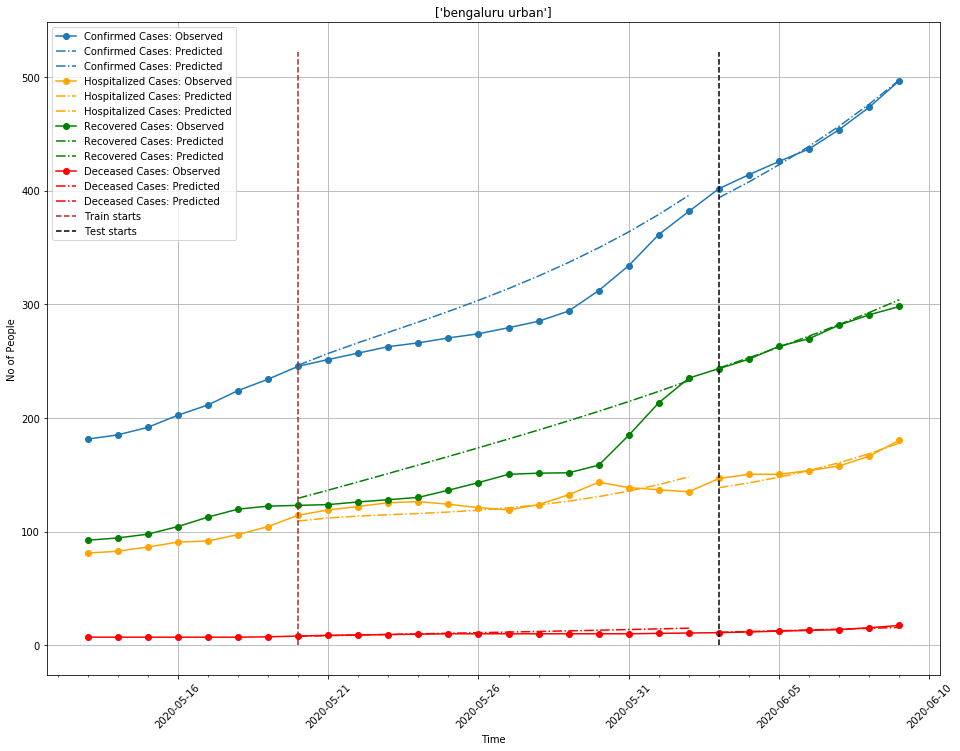

In [86]:
with open('../config/sample_homogeneous_forecast_config.json') as f_forecast:
    forecast_config = json.load(f_forecast)

forecast_config['model_class'] = "homogeneous_ensemble"
forecast_config['region_name'] = ['bengaluru urban']
forecast_config['region_type'] = 'district'
forecast_config['run_day'] = dates['t1b_end']
forecast_config['test_start_date'] = dates['test_start']
forecast_config['test_end_date'] = dates['test_end']
forecast_config['data_source'] = "direct_csv"
forecast_config['input_filepath'] = '/Users/harsh.maheshwari/Downloads/bengaluru_urban_july_16th.csv'
forecast_config['model_parameters'] = trainb_output['model_parameters']
forecast_config['output_filepath'] = None
    
plot_m1(train1_model_params = forecast_config, train1_run_day = dates['t1c_run'],
        train1_start_date = dates['t1c_start'], train1_end_date = dates['t1b_end'], 
        test_run_day = dates['t1b_end'], test_start_date = dates['test_start'],
            test_end_date = dates['test_end'], forecast_config = forecast_config, uncertainty=False, rolling_average=False, plot_config='../notebooks/plot_config.json',
            plot_name='default.png')

# Beta Trials and their Losses
### (Edited code to print beta and loss)


In [90]:
with open('../config/sample_homogeneous_train_config.json') as f:
    trainb_config = json.load(f)


trainb_config['region_name'] = ['bengaluru urban']
trainb_config['region_type'] = 'district'
trainb_config['train_start_date'] = dates['t1b_start']
trainb_config['train_end_date'] = dates['t1b_end']
trainb_config['search_parameters']['max_evals'] = 100
trainb_config['data_source'] = "direct_csv"
trainb_config['input_filepath'] = '/Users/harsh.maheshwari/Downloads/bengaluru_urban_july_16th.csv'
trainb_config['output_filepath'] = "testing"

trainb_config['model_parameters'].update(trainc_output['model_parameters'])
trainb_config['model_parameters']['modes']['training_mode'] = 'only_beta'
trainb_config['search_space']['beta'] = [0,8]

In [91]:
trainb_config

{'data_source': 'direct_csv',
 'region_name': ['bengaluru urban'],
 'region_type': 'district',
 'train_start_date': '5/27/20',
 'train_end_date': '6/2/20',
 'model_class': 'homogeneous_ensemble',
 'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'only_beta', 'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.23529320045731722,
     'deceased_period': 10.746141178957046,
     'exposed_ratio': 0.021305583501909406,
     'infectious_period': 3.000356340603214,
     'r0': 1.634565300398837,
     'recovered_ratio': 0.9485290206002538,
     'recovery_period': 14.647340

In [92]:
trainb_config = TrainingModuleConfig.parse_obj(trainb_config)
trainb_output = TrainingModule.from_config(trainb_config)

7.700625282357005 9.938192255895157                    
2.1954964948309046 11.092093496251527                                           
2.8344167142070775 9.999820730578481                                            
4.506745088897395 9.037658256905948                                             
7.148666137936103 9.752674783727466                                             
1.4547947067084248 12.346372226528862                                           
1.8899601379213342 11.608880323238228                                           
5.450893451513079 9.154450992916688                                             
0.17393204198831125 15.4445393673803                                            
7.890577859728853 9.996427606822301                                             
6.6292817006957305 9.551718261175932                                             
6.200621529455028 9.361849277122966                                              
2.71889192812574 10.192337633505161                

100%|██████████| 100/100 [01:36<00:00,  1.04trial/s, best loss: 9.006467610245021]
Best fit: {'beta': 4.826702576890212}
Best Loss: 9.006467610245021


## Sample Code for full training
### (Half train period for constituent models, half for beta)

In [5]:
with open('../config/sample_homogeneous_train_config.json') as f_train_1, \
    open('../config/sample_ensemble_train_config.json') as f_train_2, \
    open('../config/sample_ensemble_test_config.json') as f_test, \
    open('../config/sample_ensemble_forecasting_config.json') as f_forecast:
    default_train_config = json.load(f_train_1)
    ensemble_train_config = json.load(f_train_2)
    ensemble_test_config = json.load(f_test)
    ensemble_forecast_config = json.load(f_forecast)

current_day = datetime.now().date() - timedelta(23)

dates = set_dates(current_day)
    
train1_start_date = dates['train1_start_date']
train1_end_date = dates['train1_end_date']
train1_run_day = dates['train1_run_day']

train2_start_date = dates['train2_start_date']
train2_end_date = dates['train2_end_date']
train2_run_day = dates['train2_run_day']

test_start_date = dates['test_start_date']
test_end_date = dates['test_end_date']
test_run_day = dates['test_run_day']

default_train_config['region_name'] = ['bengaluru urban']
default_train_config['region_type'] = 'district'
default_train_config['train_start_date'] = train1_start_date
default_train_config['train_end_date'] = train1_end_date
default_train_config['search_parameters']['child_model']['max_evals'] = 100
default_train_config['search_parameters']['ensemble_model']['max_evals'] = 1000
default_train_config['ensemble'] = "True"
default_train_config['data_source'] = "tracker_district_daily"
default_train_config['output_filepath'] = "testing"

#default_train_config['model_parameters'].update(training_output['model_parameters'])
default_train_config['model_parameters']['modes']['training_mode'] = 'full'
# default_train_config['search_space'] = {'beta': [0,2]}

In [6]:
train_config = TrainingModuleConfig.parse_obj(default_train_config)
training_output = TrainingModule.from_config(train_config)

100%|██████████| 1000/1000 [00:56<00:00, 17.58trial/s, best loss: 12.976691129248389]
Best fit: {'beta': 0.5074558469002797}
Best Loss: 12.976691129248389


In [7]:
training_output

{'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'n': 50,
  'modes': {'training_mode': 'full', 'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.07342111676009003,
     'deceased_period': 8.939363124273276,
     'exposed_ratio': 1.5073177106398126,
     'infectious_period': 4.369008622424991,
     'r0': 2.1020927656483614,
     'recovered_ratio': 0.9048184922642719,
     'recovery_period': 12.919257649293414,
     'Latent_exposed_ratio': {'6/8/20': 1.5073177106398126,
      '6/12/20': 0.8788390167953767},
     'Latent_active_ratio': {'6/8/20': 0.07342111676009003,
      '6/12/20': 0.489974477850754

## Sample Code for forecasting

In [53]:
with open('../config/sample_homogeneous_forecast_config.json') as f_forecast:
    default_forecast_config = json.load(f_forecast)

current_day = datetime.now().date() - timedelta(23)

dates = set_dates(current_day)
default_forecast_config['model_parameters'].update(training_output['model_parameters'])
train1_start_date = dates['train1_start_date']
train1_end_date = dates['train1_end_date']
train1_run_day = dates['train1_run_day']

train2_start_date = dates['train2_start_date']
train2_end_date = dates['train2_end_date']
train2_run_day = dates['train2_run_day']

test_start_date = dates['test_start_date']
test_end_date = dates['test_end_date']
test_run_day = dates['test_run_day']

default_forecast_config['region_name'] = ['bengaluru urban']
default_forecast_config['region_type'] = 'district'
default_forecast_config['forecast_start_date'] = test_start_date
default_forecast_config['forecast_end_date'] = test_end_date
default_forecast_config['run_day'] = test_run_day
default_forecast_config['data_source'] = "tracker_district_daily"
default_forecast_config['output_filepath'] = "testing"
default_forecast_config['model_parameters']['modes']['predict_mode'] = 'predictions_with_uncertainty'
default_forecast_config['model_parameters']['uncertainty_parameters']['include_mean'] = True
default_forecast_config['model_parameters']['uncertainty_parameters']['percentiles'] = [80, 90]
default_forecast_config['model_parameters']['uncertainty_parameters']['date_of_interest'] = datetime.strftime(datetime.strptime(dates['test_start_date'], "%m/%d/%y")+timedelta(days=1), "%-m/%-d/%y")

In [46]:
default_forecast_config

{'data_source': 'tracker_district_daily',
 'region_name': ['bengaluru urban'],
 'region_type': 'district',
 'run_day': '6/15/20',
 'forecast_start_date': '6/16/20',
 'forecast_end_date': '6/23/20',
 'model_class': 'homogeneous_ensemble',
 'forecast_variables': ['confirmed', 'recovered', 'deceased'],
 'model_parameters': {'child_model': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'}}},
  'modes': {'training_mode': 'full',
   'predict_mode': 'predictions_with_uncertainty'},
  'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
    'model_parameters': {'incubation_period': 5,
     'latent_information': {'latent_variables': ['exposed', 'active'],
      'latent_on': 'confirmed'},
     'active_ratio': 0.07342111676009003,
     'deceased_period': 8.939363124273276,
     'exposed_ratio': 1.5073177106398126,
     'infectious_period': 4.369008622424991,
     '

In [47]:
forecast_config = ForecastingModuleConfig.parse_obj(default_forecast_config)
forecast_config

ForecastingModuleConfig(data_source=<DataSource.tracker_district_daily: 'tracker_district_daily'>, region_name=['bengaluru urban'], region_type='district', model_class=<ModelClass.homogeneous_ensemble: 'homogeneous_ensemble'>, model_parameters={'child_model': {'model_class': 'SEIHRD_gen', 'model_parameters': {'incubation_period': 5, 'latent_information': {'latent_variables': ['exposed', 'active'], 'latent_on': 'confirmed'}}}, 'modes': {'training_mode': 'full', 'predict_mode': 'predictions_with_uncertainty'}, 'constituent_models': {'0': {'model_class': 'SEIHRD_gen', 'model_parameters': {'incubation_period': 5, 'latent_information': {'latent_variables': ['exposed', 'active'], 'latent_on': 'confirmed'}, 'active_ratio': 0.07342111676009003, 'deceased_period': 8.939363124273276, 'exposed_ratio': 1.5073177106398126, 'infectious_period': 4.369008622424991, 'r0': 2.1020927656483614, 'recovered_ratio': 0.9048184922642719, 'recovery_period': 12.919257649293414, 'Latent_exposed_ratio': {'6/8/20':

In [48]:
forecasting_output = ForecastingModule.from_config(forecast_config)

6/17/20


In [49]:
forecasting_output

Region Type           Region Country  Lat  Long    prediction_type  \
0     district  bengaluru urban   India   20    70        active_mean   
1     district  bengaluru urban   India   20    70            exposed   
2     district  bengaluru urban   India   20    70  hospitalized_mean   
3     district  bengaluru urban   India   20    70     recovered_mean   
4     district  bengaluru urban   India   20    70      deceased_mean   
5     district  bengaluru urban   India   20    70     confirmed_mean   
6     district  bengaluru urban   India   20    70          active_80   
7     district  bengaluru urban   India   20    70         exposed_80   
8     district  bengaluru urban   India   20    70    hospitalized_80   
9     district  bengaluru urban   India   20    70       recovered_80   
10    district  bengaluru urban   India   20    70        deceased_80   
11    district  bengaluru urban   India   20    70       confirmed_80   
12    district  bengaluru urban   India   20    70          active_90   
13    district  bengaluru urban   India   20    70         exposed_90   
14    district  bengaluru urban   India   20    70    hospitalized_90   
15    district  bengaluru urban   India   20    70       recovered_90   
16    district  bengaluru urban   India   20    70        deceased_90   
17    district  bengaluru urban   India   20    70       confirmed_90   
18    district  bengaluru urban   India   20    70         active_2.5   
19    district  bengaluru urban   India   20    70        exposed_2.5   
20    district  bengaluru urban   India   20    70   hospitalized_2.5   
21    district  bengaluru urban   India   20    70      recovered_2.5   
22    district  bengaluru urban   India   20    70       deceased_2.5   
23    district  bengaluru urban   India   20    70      confirmed_2.5   
24    district  bengaluru urban   India   20    70        active_97.5   
25    district  bengaluru urban   India   20    70       exposed_97.5   
26    district  bengaluru urban   India   20    70  hospitalized_97.5   
27    district  bengaluru urban   India   20    70     recovered_97.5   
28    district  bengaluru urban   India   20    70      deceased_97.5   
29    district  bengaluru urban   India   20    70     confirmed_97.5   

        6/16/20      6/17/20      6/18/20      6/19/20      6/20/20  \
0    457.480122   514.450319   574.071827   637.684429   706.922757   
1    718.412316   776.421437   846.521406   928.729697  1022.900792   
2    385.520726   439.759824   499.220783   564.185758   634.903539   
3    348.189928   382.166239   420.725379   464.253844   513.205630   
4     34.945372    39.040152    43.673168    48.890104    54.744913   
5    768.656026   860.966215   963.619330  1077.329705  1202.854083   
6    401.552986   441.927895   481.970249   522.547513   564.721219   
7    648.473145   685.734366   730.608352   782.456477   840.417719   
8    385.836949   438.895341   495.368340   555.263405   618.497586   
9    350.638208   387.415515   429.020234   475.693717   527.729724   
10    33.967095    37.039108    40.583450    44.625779    49.195912   
11   770.442253   863.349964   964.972025  1075.582902  1195.423222   
12   862.426150  1008.323358  1168.140123  1345.720876  1545.766743   
13  1271.001223  1421.409300  1605.926779  1826.420288  2084.594345   
14   412.943828   501.265648   602.347322   717.606605   848.575438   
15   342.576421   372.219710   408.100937   451.050656   502.050594   
16    35.393979    40.243618    46.008366    52.809786    60.792998   
17   790.914228   913.728976  1056.456625  1221.467046  1411.419029   
18   300.106038   312.682014   325.690207   339.066095   352.736034   
19   359.879953   373.596831   387.946901   403.053178   419.051487   
20   346.036221   356.159395   367.184172   379.144360   392.087122   
21   359.719155   402.330023   446.309525   491.737747   538.691643   
22    39.206667    47.236200    55.458810    63.895928    72.567301   
23   744.962043   805.725617   868.

## Test for get_params_for_percentiles

In [54]:
default_forecast_config['model_parameters']

{'child_model': {'model_class': 'SEIHRD_gen',
  'model_parameters': {'incubation_period': 5,
   'latent_information': {'latent_variables': ['exposed', 'active'],
    'latent_on': 'confirmed'}}},
 'modes': {'training_mode': 'full',
  'predict_mode': 'predictions_with_uncertainty'},
 'constituent_models': {'0': {'model_class': 'SEIHRD_gen',
   'model_parameters': {'incubation_period': 5,
    'latent_information': {'latent_variables': ['exposed', 'active'],
     'latent_on': 'confirmed'},
    'active_ratio': 0.07342111676009003,
    'deceased_period': 8.939363124273276,
    'exposed_ratio': 1.5073177106398126,
    'infectious_period': 4.369008622424991,
    'r0': 2.1020927656483614,
    'recovered_ratio': 0.9048184922642719,
    'recovery_period': 12.919257649293414,
    'Latent_exposed_ratio': {'6/8/20': 1.5073177106398126,
     '6/12/20': 0.8788390167953767},
    'Latent_active_ratio': {'6/8/20': 0.07342111676009003,
     '6/12/20': 0.4899744778507541}}},
  '1': {'model_class': 'SEIHRD_

In [61]:
from model_wrappers.model_factory import ModelFactory
from modules.data_fetcher_module import DataFetcherModule

In [60]:
model = ModelFactory.get_model("homogeneous_ensemble", default_forecast_config['model_parameters'])

In [63]:
observations = DataFetcherModule.get_observations_for_region('district', ['bengaluru urban'], data_source="tracker_district_daily")
region_metadata = DataFetcherModule.get_regional_metadata('district', ['bengaluru urban'], data_source="tracker_district_daily")

In [68]:

paramDict = model.get_params_for_percentiles(column_of_interest = 'confirmed', 
                                 date_of_interest = default_forecast_config['model_parameters']['uncertainty_parameters']['date_of_interest'], 
                                 tolerance = 1, 
                                 percentiles = [80, 90], 
                                 region_metadata = region_metadata, 
                                 region_observations= observations,
                                 run_day = dates['test_run_day'], 
                                 start_date = dates['test_start_date'], 
                                 end_date = dates['test_end_date'])

In [71]:
paramDict

{80: {'incubation_period': 5,
  'latent_information': {'latent_variables': [<ForecastVariable.exposed: 'exposed'>,
    <ForecastVariable.active: 'active'>],
   'latent_on': <ForecastVariable.confirmed: 'confirmed'>},
  'active_ratio': 0.11154187572410479,
  'deceased_period': 14.366648766360283,
  'exposed_ratio': 1.5644222959987866,
  'infectious_period': 4.540263268756211,
  'r0': 2.021725257676746,
  'recovered_ratio': 0.8965366340611354,
  'recovery_period': 10.004414501824064,
  'Latent_exposed_ratio': {'6/8/20': 1.5644222959987866,
   '6/12/20': 0.9037699314239892},
  'Latent_active_ratio': {'6/8/20': 0.11154187572410479,
   '6/12/20': 0.5213678644199244}},
 90: {'incubation_period': 5,
  'latent_information': {'latent_variables': [<ForecastVariable.exposed: 'exposed'>,
    <ForecastVariable.active: 'active'>],
   'latent_on': <ForecastVariable.confirmed: 'confirmed'>},
  'active_ratio': 0.10808621116935456,
  'deceased_period': 9.669054483434662,
  'exposed_ratio': 2.77746908583

In [20]:
ensemble_train_config['model_parameters']['constituent_models'] = training_output['model_parameters']['constituent_models']

In [21]:
ensemble_train_config['model_parameters']['constituent_model_losses'] = training_output['model_parameters']['constituent_model_losses']

In [22]:
ensemble_train_config['model_parameters']['modes']['predict_mode'] = 'without_uncertainty'

In [23]:
ensemble_train_config

{'model_class': 'heterogeneous_ensemble',
 'ensemble': 'False',
 'train_start_date': '',
 'train_end_date': '',
 'model_parameters': {'constituent_models': {'0': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 3.0355865552573826,
     'F_fatalities': 0.05236163703523315,
     'F_hospitalization': 0.038389934344751075,
     'IbyCRatio': 1.3562231831212739,
     'beta': 0.6578217217815268,
     'infectious_period': 5.071749969688699,
     'r0': 2.447583916790987,
     'LatentEbyCRatio': {'5/28/20': 3.0355865552573826,
      '6/4/20': 1.309259396213552},
     'LatentIbyCRatio': {'5/28/20': 1.3562231831212739,
      '6/4/20': 0.3258005981661483}}},
   '1': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 16.6326234653206,
     'F_fatalities': 0.08797400616905801,
     'F_hospitalization': 0.05013940078443814,
     'IbyCRatio': 1.8488568538775076,
     'beta': 1.9

In [24]:
params, metrics, train1_model_params, train2_model_params = train_eval(['bengaluru urban'], 'district', 
                                                                       train1_start_date, train1_end_date, 
                                                                       train2_start_date, train2_end_date, train2_run_day,
                                                                       test_start_date, test_end_date,
                                                                       ensemble_train_config, ensemble_test_config,
                                                                       max_evals=10, data_source='tracker_district_daily',
                                                                       mlflow_log=False, name_prefix="testing")

t = 7.90                                              
t = 7.90                                              
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        
t = 7.90                                                                        

In [25]:
params

{'region': 'bengaluru urban',
 'region_type': 'district',
 'train1_start_date': '5/29/20',
 'train1_end_date': '6/4/20',
 'train2_start_date': '6/5/20',
 'train2_end_date': '6/12/20',
 'run_day': '6/4/20',
 'test_start_date': '6/5/20',
 'test_end_date': '6/12/20',
 'data_source': 'tracker_district_daily'}

In [26]:
metrics

{'Train1RMLSE': 0,
 'Train1MAPE': 455.39553041737975,
 'Train1_mape_confirmed': 107.14198422943446,
 'Train1_mape_confirmed_weight': 1.0,
 'Train1_mape_hospitalized': 93.80937702332781,
 'Train1_mape_hospitalized_weight': 1.0,
 'Train1_mape_recovered': 115.79245298223893,
 'Train1_mape_recovered_weight': 1.0,
 'Train1_mape_deceased': 138.65171618237855,
 'Train1_mape_deceased_weight': 1.0,
 'TestMAPE': 219.8526662172936,
 'TestRMLSE': 0,
 'Test_mape_confirmed': 35.97470750775164,
 'Test_mape_confirmed_weight': 1.0,
 'Test_mape_hospitalized': 12.746292717102566,
 'Test_mape_hospitalized_weight': 1.0,
 'Test_mape_recovered': 69.14641176310691,
 'Test_mape_recovered_weight': 1.0,
 'Test_mape_deceased': 58.01472098587376,
 'Test_mape_deceased_weight': 1.0,
 'Train2MAPE': 175.88213297383484,
 'Train2RMLSE': 0,
 'Train2_mape_confirmed': 35.974707507751624,
 'Train2_mape_confirmed_weight': 1.0,
 'Train2_mape_hospitalized': 12.746292717102564,
 'Train2_mape_hospitalized_weight': 1.0,
 'Train2_

In [27]:
train1_model_params

{'data_source': 'tracker_district_daily',
 'region': ['bengaluru urban'],
 'region_type': 'district',
 'model_type': 'heterogeneous_ensemble',
 'model_parameters': {'constituent_models': {'0': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 3.0355865552573826,
     'F_fatalities': 0.05236163703523315,
     'F_hospitalization': 0.038389934344751075,
     'IbyCRatio': 1.3562231831212739,
     'beta': 0.6578217217815268,
     'infectious_period': 5.071749969688699,
     'r0': 2.447583916790987,
     'LatentEbyCRatio': {'5/28/20': 3.0355865552573826,
      '6/4/20': 1.309259396213552},
     'LatentIbyCRatio': {'5/28/20': 1.3562231831212739,
      '6/4/20': 0.3258005981661483}}},
   '1': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 16.6326234653206,
     'F_fatalities': 0.08797400616905801,
     'F_hospitalization': 0.05013940078443814,
     'IbyCRatio': 1.848

In [28]:
train2_model_params

{'data_source': 'tracker_district_daily',
 'region': ['bengaluru urban'],
 'region_type': 'district',
 'model_type': 'heterogeneous_ensemble',
 'model_parameters': {'constituent_models': {'0': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 3.0355865552573826,
     'F_fatalities': 0.05236163703523315,
     'F_hospitalization': 0.038389934344751075,
     'IbyCRatio': 1.3562231831212739,
     'beta': 0.6578217217815268,
     'infectious_period': 5.071749969688699,
     'r0': 2.447583916790987,
     'LatentEbyCRatio': {'5/28/20': 3.0355865552573826,
      '6/4/20': 1.309259396213552},
     'LatentIbyCRatio': {'5/28/20': 1.3562231831212739,
      '6/4/20': 0.3258005981661483}}},
   '1': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 16.6326234653206,
     'F_fatalities': 0.08797400616905801,
     'F_hospitalization': 0.05013940078443814,
     'IbyCRatio': 1.848

In [29]:
import pandas as pd
model_parameters = train2_model_params['model_parameters']
model_parameters['constituent_models']['0']['model_parameters']['r0'] = 3.4
param_of_interest = 'r0'
params_dict = dict()
weights = {'0':0.5, '1':0.5} 
for idx in model_parameters['constituent_model_losses']:
    params_dict[idx] = [weights[idx], 
                        model_parameters['constituent_models'][idx]['model_parameters'][param_of_interest],
                       ]
    
params_df = pd.DataFrame.from_dict(params_dict, orient = 'index', columns = ['weight', 'ParamOfInterest'])


In [30]:
params_df

weight  ParamOfInterest
0     0.5         3.400000
1     0.5         0.506902

In [31]:
from utils.distribution_util import weights_to_pdf, pdf_to_cdf, get_best_index

params_df['pdf'] = weights_to_pdf(params_df['weight'])
params_df = params_df.sort_values(by='ParamOfInterest').reset_index()
params_df['cdf'] = pdf_to_cdf(params_df['pdf'])

In [32]:
params_df

index  weight  ParamOfInterest  pdf  cdf
0     1     0.5         0.506902  0.5  0.5
1     0     0.5         3.400000  0.5  1.0

In [33]:

percentiles_dict = dict()
def get_best_index(df, percentile):
    df['diff'] = (df['cdf'] - percentile / 100).apply(abs)
    idx = (df['diff']).idxmin()
    df.drop(['diff'], axis = 1, inplace = True)
    return df.iloc[idx]['index']

for p in [45, 95]:
    percentiles_dict[p] = get_best_index(params_df, p)
    

In [34]:
percentiles_dict.pop(4)

KeyError: 4

In [35]:
tempDict = {"level1": {"level2": 2}, "level12": 23}

In [36]:
tempDict

{'level1': {'level2': 2}, 'level12': 23}

In [37]:
tempDict.update({"level11":2223})
tempDict

{'level1': {'level2': 2}, 'level12': 23, 'level11': 2223}

In [38]:
params_df

index  weight  ParamOfInterest  pdf  cdf
0     1     0.5         0.506902  0.5  0.5
1     0     0.5         3.400000  0.5  1.0

In [39]:
forecast_start_date = '6/2/20'
forecast_length = 30
forecast_run_day = (datetime.strptime(forecast_start_date, "%m/%d/%y") - timedelta(days=1)).strftime("%-m/%-d/%y")
forecast_end_date = (datetime.strptime(forecast_start_date, "%m/%d/%y") + timedelta(days=forecast_length)).strftime("%-m/%-d/%y")

In [40]:
train2_model_params['model_parameters']['modes']['predict_mode'] = 'without_uncertainty'
forecast(train2_model_params, forecast_run_day, forecast_start_date, forecast_end_date, ensemble_forecast_config)

t = 31.90
t = 31.90


prediction_type    index        exposed     icu_mean  recovered_mean  \
0                 6/2/20    1238.445407     9.086006      272.942585   
1                 6/3/20    1433.541613    11.824933      347.868916   
2                 6/4/20    1679.448811    14.844964      443.600337   
3                 6/5/20    1980.742374    18.233664      562.459763   
4                 6/6/20    2341.895010    22.075828      707.405597   
5                 6/7/20    2772.030878    26.497956      882.113959   
6                 6/8/20    3284.141574    31.651045     1091.298881   
7                 6/9/20    3892.366760    37.692728     1340.789821   
8                6/10/20    4612.881412    44.798493     1637.602571   
9                6/11/20    5466.753587    53.181173     1990.167952   
10               6/12/20    6479.029986    63.087115     2408.544783   
11               6/13/20    7679.502574    74.823100     2904.789969   
12               6/14/20    9102.790028    88.738393     3493.341596   
13               6/15/20   10788.344934   105.211179     4191.279756   
14               6/16/20   12785.691804   124.756047     5018.780536   
15               6/17/20   15149.923102   147.845228     5999.818090   
16               6/18/20   17945.845078   175.097980     7162.025339   
17               6/19/20   21254.569467   207.386348     8538.427821   
18               6/20/20   25173.513487   245.753272    10168.995624   
19               6/21/20   29816.399836   291.357232    12101.692605   
20               6/22/20   35313.256699   345.434821    14393.185728   
21               6/23/20   41813.427404   409.325622    17109.332710   
22               6/24/20   49565.451788   485.654571    20329.555936   
23               6/25/20   58728.856534   575.468535    24148.795353   
24               6/26/20   69472.078202   680.508632    28669.835703   
25               6/27/20   82046.523914   803.942786    34013.136057   
26               6/28/20   96786.571345   949.903543    40325.589594   
27               6/29/20  114109.568730  1123.175594    47786.445790   
28               6/30/20  134515.834860  1328.984526    56611.314230   
29                7/1/20  158588.659082  1572.854001    67054.871449   
30                7/2/20  186972.919640  1860.444513    79412.655577   

prediction_type  deceased_mean  confirmed_mean  hospitalized_mean  \
0                    15.081408      469.744121         181.720128   
1                    19.221453      603.589031         236.498662   
2                    24.511080      765.010693         296.899276   
3                    31.078643      958.211688         364.673282   
4                    39.087606     1188.009759         441.516556   
5                    48.741094     1460.814178         529.959125   
6                    60.299581     1784.619352         633.020890   
7                    74.085171     2168.729556         753.854564   
8                    90.485521     2624.057951         895.969859   
9                   109.966477     3163.757884        1063.623456   
10                  133.083835     3803.370911        1261.742293   
11                  160.503800     4561.755762        1496.461993   
12                  193.024145     5461.133593        1774.767852   
13                  231.588629     6527.091959        2104.223575   
14                  277.312079     7791.213564        2495.120948   
15                  331.519184     9288.241832        2956.904558   
16                  395.736798    11059.721745        3501.959608   
17                  471.789742    13157.944521        4147.726959   
18                  561.886558    15645.947618        4915.065436   
19                  668.677483    18597.514728        5827.144640   
20                  795.293644    22097.175783        6908.696411   
21                  945.374000    26241.219151        8186.512441   
22                 1123.307024    31165.954382        9713.091423   
23                 1334.338611    36992

t = 7.90
t = 7.90
t = 8.90
t = 8.90


/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


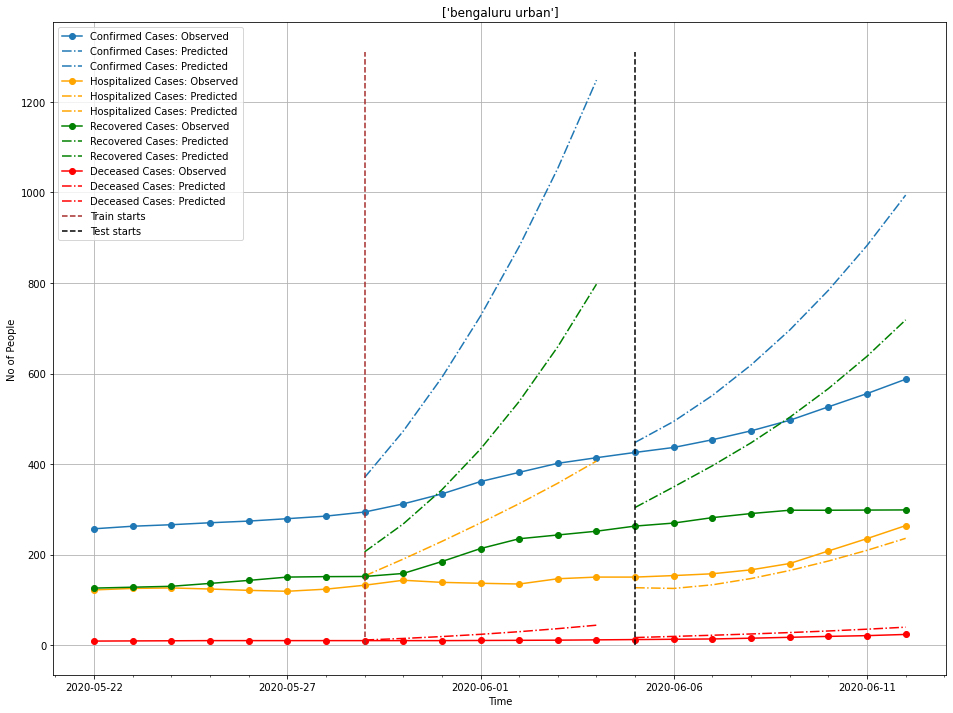

In [41]:
plot_m1(train1_model_params, train1_run_day, train1_start_date, train1_end_date, 
        test_run_day, test_start_date, test_end_date, 
        rolling_average = False, uncertainty = False, 
        forecast_config = '../config/sample_ensemble_forecasting_config.json',
        plot_config = '../notebooks/plot_config.json', plot_name = 'm1.png')

t = 8.90
t = 8.90


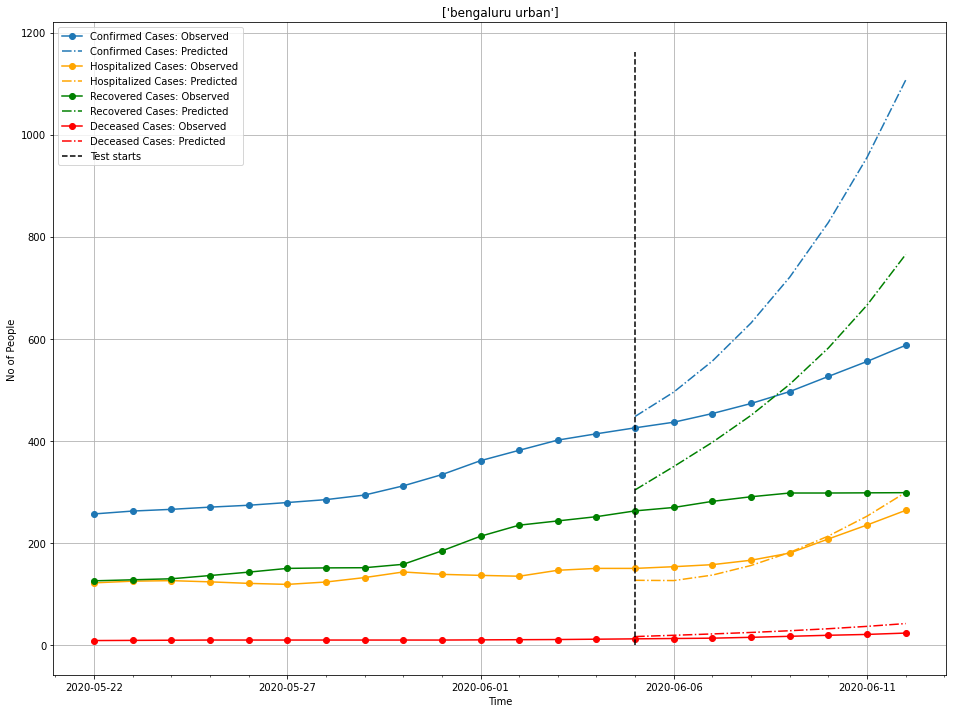

In [42]:
plot_m2(train2_model_params, train1_start_date, train1_end_date,
        test_run_day, test_start_date, test_end_date, 
        rolling_average = False, uncertainty = False, 
        forecast_config = '../config/sample_ensemble_forecasting_config.json',
        plot_config = '../notebooks/plot_config.json', plot_name = 'm2.png')

t = 31.90
t = 31.90


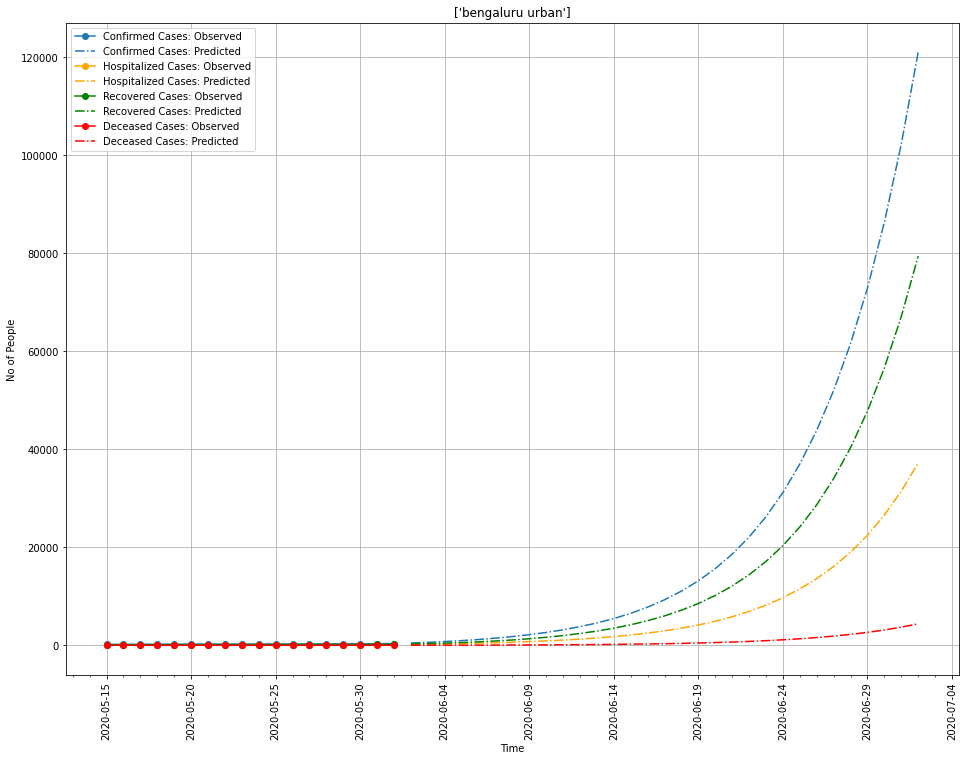

In [43]:
plot_m3(train2_model_params, train1_start_date, 
        forecast_start_date, forecast_length, 
        rolling_average = False, uncertainty = False,
        forecast_config = '../config/sample_ensemble_forecasting_config.json',
        plot_config = '../notebooks/plot_config.json', plot_name = 'm3.png')

In [44]:
train2_model_params

{'data_source': 'tracker_district_daily',
 'region': ['bengaluru urban'],
 'region_type': 'district',
 'model_type': 'heterogeneous_ensemble',
 'model_parameters': {'constituent_models': {'0': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 3.0355865552573826,
     'F_fatalities': 0.05236163703523315,
     'F_hospitalization': 0.038389934344751075,
     'IbyCRatio': 1.3562231831212739,
     'beta': 0.6578217217815268,
     'infectious_period': 5.071749969688699,
     'r0': 3.4,
     'LatentEbyCRatio': {'5/28/20': 3.0355865552573826,
      '6/4/20': 1.309259396213552},
     'LatentIbyCRatio': {'5/28/20': 1.3562231831212739,
      '6/4/20': 0.3258005981661483}}},
   '1': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 16.6326234653206,
     'F_fatalities': 0.08797400616905801,
     'F_hospitalization': 0.05013940078443814,
     'IbyCRatio': 1.8488568538775076,

In [45]:
train2_model_params['model_parameters']['modes']['predict_mode'] = 'with_uncertainty'

In [46]:
train2_model_params['model_parameters']['uncertainty_parameters'] = {
            "include_mean": "True",
            "percentiles": [10, 20, 30, 40, 50, 60, 70, 80, 90],
            "ci": 95,
            "date_of_interest": "6/3/20",
            "column_of_interest": "hospitalized",
            "window": 5
        }

In [47]:
train2_model_params

{'data_source': 'tracker_district_daily',
 'region': ['bengaluru urban'],
 'region_type': 'district',
 'model_type': 'heterogeneous_ensemble',
 'model_parameters': {'constituent_models': {'0': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 3.0355865552573826,
     'F_fatalities': 0.05236163703523315,
     'F_hospitalization': 0.038389934344751075,
     'IbyCRatio': 1.3562231831212739,
     'beta': 0.6578217217815268,
     'infectious_period': 5.071749969688699,
     'r0': 3.4,
     'LatentEbyCRatio': {'5/28/20': 3.0355865552573826,
      '6/4/20': 1.309259396213552},
     'LatentIbyCRatio': {'5/28/20': 1.3562231831212739,
      '6/4/20': 0.3258005981661483}}},
   '1': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 16.6326234653206,
     'F_fatalities': 0.08797400616905801,
     'F_hospitalization': 0.05013940078443814,
     'IbyCRatio': 1.8488568538775076,

In [48]:
uncertainty_df = forecast(train2_model_params, forecast_run_day, forecast_start_date, forecast_end_date, ensemble_forecast_config)

t = 31.90
t = 31.90
t = 31.90
t = 31.90


In [49]:
pd.set_option("display.max_columns", None)
uncertainty_df

prediction_type    index        exposed     icu_mean  recovered_mean  \
0                 6/2/20    1238.445407     9.086006      272.942585   
1                 6/3/20    1433.541613    11.824933      347.868916   
2                 6/4/20    1679.448811    14.844964      443.600337   
3                 6/5/20    1980.742374    18.233664      562.459763   
4                 6/6/20    2341.895010    22.075828      707.405597   
5                 6/7/20    2772.030878    26.497956      882.113959   
6                 6/8/20    3284.141574    31.651045     1091.298881   
7                 6/9/20    3892.366760    37.692728     1340.789821   
8                6/10/20    4612.881412    44.798493     1637.602571   
9                6/11/20    5466.753587    53.181173     1990.167952   
10               6/12/20    6479.029986    63.087115     2408.544783   
11               6/13/20    7679.502574    74.823100     2904.789969   
12               6/14/20    9102.790028    88.738393     3493.341596   
13               6/15/20   10788.344934   105.211179     4191.279756   
14               6/16/20   12785.691804   124.756047     5018.780536   
15               6/17/20   15149.923102   147.845228     5999.818090   
16               6/18/20   17945.845078   175.097980     7162.025339   
17               6/19/20   21254.569467   207.386348     8538.427821   
18               6/20/20   25173.513487   245.753272    10168.995624   
19               6/21/20   29816.399836   291.357232    12101.692605   
20               6/22/20   35313.256699   345.434821    14393.185728   
21               6/23/20   41813.427404   409.325622    17109.332710   
22               6/24/20   49565.451788   485.654571    20329.555936   
23               6/25/20   58728.856534   575.468535    24148.795353   
24               6/26/20   69472.078202   680.508632    28669.835703   
25               6/27/20   82046.523914   803.942786    34013.136057   
26               6/28/20   96786.571345   949.903543    40325.589594   
27               6/29/20  114109.568730  1123.175594    47786.445790   
28               6/30/20  134515.834860  1328.984526    56611.314230   
29                7/1/20  158588.659082  1572.854001    67054.871449   
30                7/2/20  186972.919640  1860.444513    79412.655577   

prediction_type  deceased_mean  confirmed_mean  hospitalized_mean  \
0                    15.081408      469.744121         181.720128   
1                    19.221453      603.589031         236.498662   
2                    24.511080      765.010693         296.899276   
3                    31.078643      958.211688         364.673282   
4                    39.087606     1188.009759         441.516556   
5                    48.741094     1460.814178         529.959125   
6                    60.299581     1784.619352         633.020890   
7                    74.085171     2168.729556         753.854564   
8                    90.485521     2624.057951         895.969859   
9                   109.966477     3163.757884        1063.623456   
10                  133.083835     3803.370911        1261.742293   
11                  160.503800     4561.755762        1496.461993   
12                  193.024145     5461.133593        1774.767852   
13                  231.588629     6527.091959        2104.223575   
14                  277.312079     7791.213564        2495.120948   
15                  331.519184     9288.241832        2956.904558   
16                  395.736798    11059.721745        3501.959608   
17                  471.789742    13157.944521        4147.726959   
18                  561.886558    15645.947618        4915.065436   
19                  668.677483    18597.514728        5827.144640   
20                  795.293644    22097.175783        6908.696411   
21                  945.374000    26241.219151        8186.512441   
22                 1123.307024    31165.954382        9713.091423   
23                 1334.338611    36992